Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [14]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [15]:
#%cd ..

In [16]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [17]:
start_time='2020-05-29'
end_time='2020-06-15'
observation = 'newly_infected' # or 'hospitalization


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [18]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time)
observed = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)
print(initial_newly_infected)
df_obs.head(3)

[35 34 52 62 52 37]


,Date,number_of_deaths,newly_infected,hospitalization
0,2020-05-29,1,42,9
1,2020-05-30,4,33,7
2,2020-05-31,2,22,4


In [19]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [20]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [21]:
method = RandomWalk(num_observations, device=device, dtype=dtype)

### Initialize alpha and phi

In [22]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0746, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0100, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [23]:
def get_input_data(start, end):
  df_cluster = pd.read_csv('data/clustering/220309_percentage_careful.csv' , parse_dates=['date'])
  time_period = (df_cluster['date'] >= start) & (df_cluster['date'] < end)
  input_data = torch.tensor(df_cluster.loc[time_period]['percentage'], requires_grad=False, device=device, dtype=dtype)
  return input_data

R_input_data = get_input_data(start_time, end_time)
R_input_data

tensor([0.7037, 0.7306, 0.6162, 0.6639, 0.6699, 0.6780, 0.6566, 0.7026, 0.6481,
        0.6507, 0.7116, 0.6636, 0.6591, 0.6933, 0.6914, 0.5811, 0.6822])

# Optimization

## Training

Step: 0, Time: 0.8181507587432861, Loss: 4278301.0, Mean Expected Daily Hospit: 288.87518310546875


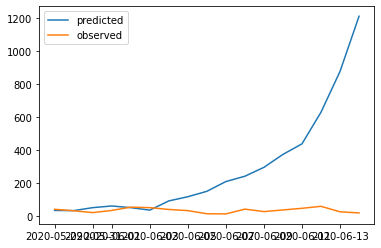

Step: 5, Time: 0.015004396438598633, Loss: 3094405.0, Mean Expected Daily Hospit: 254.31178283691406


In [24]:
epochs = 10
model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']]

params_to_be_optimized = method.get_parameters() + model_parameter

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(population, R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

  # calc loss
  comparison_loss = dict_param['real_values']['phi'] * calc_mse(expected, observed)
  method_loss = method.calculate_loss()
  loss = comparison_loss + method_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

In [25]:
method.sigma

tensor(0.0869, grad_fn=<AddBackward0>)

In [26]:
method.R0

tensor(3.5869, grad_fn=<AddBackward0>)

In [27]:
dict_param['real_values']['phi']

tensor(24.9780, grad_fn=<AddBackward0>)

In [28]:
dict_param['real_values']['alpha']

tensor(0.0100, grad_fn=<AddBackward0>)

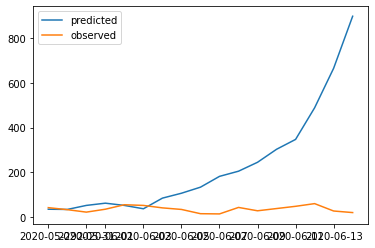

In [29]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
plt.legend()
plt.show()